In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from LIBS_handler import LIBS_Toolkit
from tqdm import tqdm

In [3]:
fname = r"E:/Data/Data_LIBS/Vidros/mixed_dset_pro"
libs_mainupulator = LIBS_Toolkit(fname, overwrite = True)

In [4]:
libs_mainupulator.load_dataset(baseline_corrected = False)

In [5]:
_ = libs_mainupulator.baseline_correct()
_ = libs_mainupulator.normalize_to_sum()

In [10]:
image_var = cv2.imread(r'Images/dset_mixture.png')
image_var = cv2.cvtColor(image_var, cv2.COLOR_BGR2RGB)

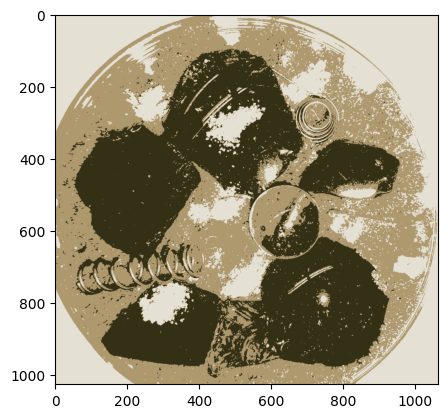

In [11]:
def kmeans_color_quantization(image, clusters = 8, rounds = 1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype = np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
color_segmented = kmeans_color_quantization(image_var, clusters = 3)

plt.figure()
plt.imshow(color_segmented)

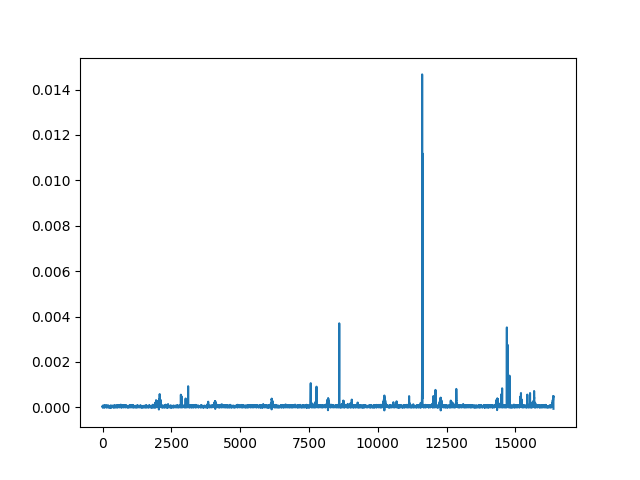

In [17]:
plt.figure()
plt.plot(libs_mainupulator.dataset[100, 100])

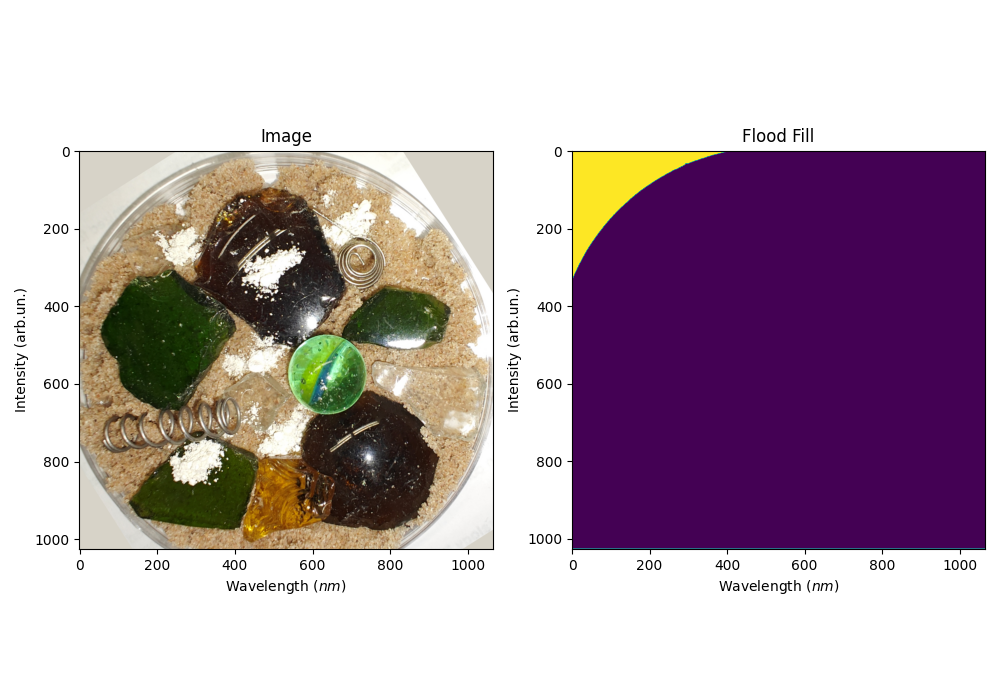

In [58]:
%matplotlib widget

fig, ax = plt.subplots(1, 2, figsize = (10, 7))

result = color_segmented.copy()
mask1 = np.zeros((result.shape[0]+2, result.shape[1]+2), np.uint8) 
seed_point = (100, 100)
cv2.floodFill(result, mask1, seedPoint = seed_point, newVal = (36, 255, 12), loDiff = (0, 0, 0, 0), upDiff = (0, 0, 0, 0))

axs = ax[0]
axs.set_title('Image')
axs.imshow(image_var)
axs.set_xlabel(r'Wavelength $(nm)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.grid(False)

axs = ax[1]
axs.imshow(mask1)
axs.set_title('Flood Fill')
axs.set_xlabel(r'Wavelength $(nm)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.grid(False)


def update_map(seed_point, result, mask1):
    cv2.floodFill(result, mask1, seedPoint = seed_point, newVal = (0, 255, 0), loDiff = (25, 25, 25, 25), upDiff = (25, 25, 25, 25))
    global mask
    mask = mask1
    im1 = ax[1].imshow(mask1) 


def onclick(event):
    if event.dblclick:
        result = color_segmented.copy()
        mask1 = np.zeros((result.shape[0]+2, result.shape[1]+2), np.uint8) 
        seed_point = (int(event.xdata), int(event.ydata))
        if event.inaxes == ax[0]:
            update_map(seed_point, result, mask1)
            fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)

fig.tight_layout()

In [39]:
mask_res = cv2.resize(mask, dsize = (libs_mainupulator.y_size, libs_mainupulator.x_size), interpolation = cv2.INTER_NEAREST)

In [56]:
inds = np.where(mask_res == 1)
th = 0.001

def covariance_score(libs_data, mask, th):
    diss = []
    for i in tqdm(range(libs_data.shape[-1])):
        B = libs_data[inds[0], inds[1], i] > th
        inter = np.sum(np.array(B == mask[mask == 1], dtype = int), axis = -1)
        dis = (np.sum(mask == 1) - inter) / np.sum(mask == 1)
        diss.append(dis)
    return 1 - np.array(diss)

def covariance_score(libs_data, mask, th):
    diss = []
    for i in tqdm(range(libs_data.shape[-1])):
        B = np.sum((mask_res[mask_res == 1] | (libs_data[inds[0], inds[1], i] > th)))
        A = np.sum((mask_res[mask_res == 1] & (libs_data[inds[0], inds[1], i] > th)))
        diss.append(A)
    return np.array(diss)/np.array(diss).max()

cov_score = covariance_score(libs_mainupulator.dataset, mask_res, th)

# cov_score = np.array([np.sum((mask_res[mask_res == 1] & (libs_mainupulator.dataset[inds[0], inds[1], i] > th)))/np.sum(((mask_res[mask_res == 1] | (libs_mainupulator.dataset[inds[0], inds[1], i] > th)))) for i in tqdm(range(libs_mainupulator.spectral_size))])

100%|██████████| 16384/16384 [00:02<00:00, 7026.97it/s]


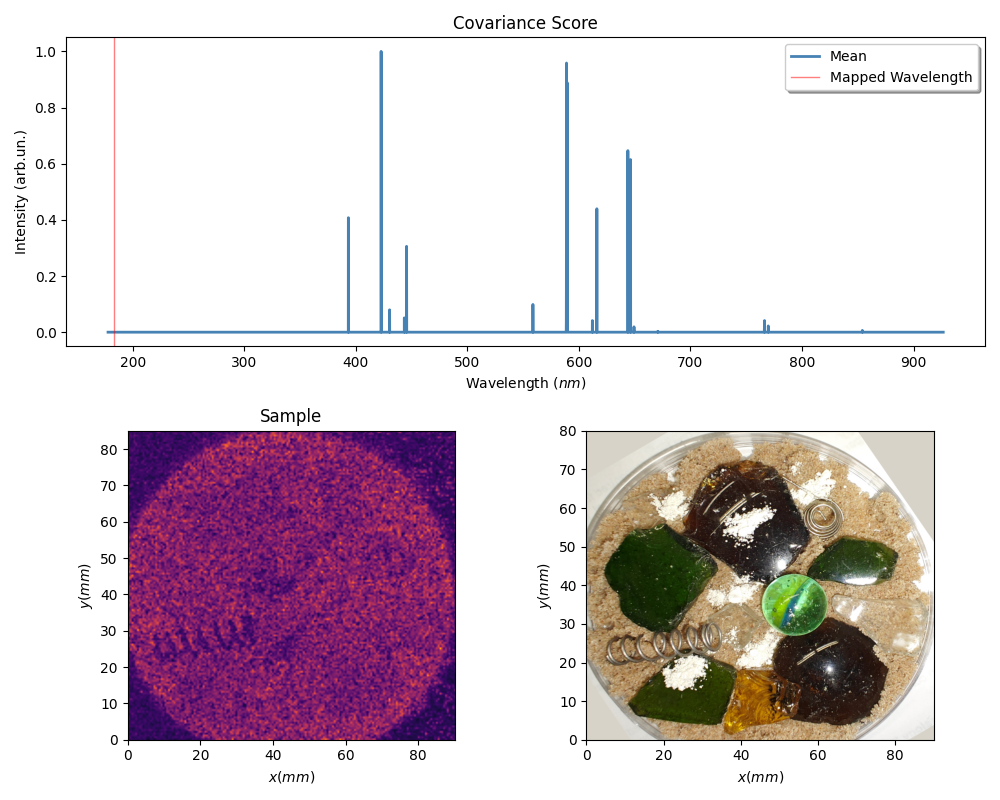

In [57]:
%matplotlib widget
from matplotlib import gridspec

# fig, ax = subplots(1, 3, figsize = [10, 7], gridspec_kw = {'width_ratios': [1.1, 0.6, 0.6]})
fig = plt.figure(tight_layout = True, figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


axs = ax1
axs.set_title('Covariance Score')
axs.plot(libs_mainupulator.wavelengths, cov_score, lw = 2, ls = '-', color = 'steelblue', label = 'Mean')

wn = 120
line = axs.axvline(libs_mainupulator.wavelengths[wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavelength')
axs.set_xlabel(r'Wavelength $(nm)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(fancybox = True, shadow = True)
axs.grid(False)

axs = ax2
axs.set_title('Sample')
# axs.imshow(image_var, extent = (0, 90, 0, 80))
# axs.imshow(spectrum[:, :, wn], cmap = my_cmap, extent = (0, 90, 0, 80), interpolation = 'gaussian')

axs.imshow(libs_mainupulator.dataset[:, :, wn], cmap = 'inferno', extent = (0, 90, 0, 85), interpolation = 'gaussian')
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')
axs.grid(False)

axs = ax3
axs.imshow(image_var, extent = (0, 90, 0, 80))
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')
axs.grid(False)


def update_map(wn):
    # ax2.imshow(image_var, extent = (0, 90, 0, 80))
    # im1 = ax2.imshow(spectrum[:, :, wn], cmap = my_cmap, extent = (0, 90, 0, 80), interpolation = 'gaussian') 
    im1 = ax2.imshow(libs_mainupulator.dataset[:, :, wn], cmap = 'inferno', extent = (0, 90, 0, 85), interpolation = 'gaussian') 
    line.set_xdata([libs_mainupulator.wavelengths[wn]])

def onclick(event):
    if event.dblclick:
        ix, iy = event.xdata, event.ydata
        wn = libs_mainupulator.wavelength_to_index(ix)
        if event.inaxes == ax1:
            update_map(wn)
            fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()